# Main

In [1]:
from utils import *
import json

c:\Users\julian.quintero\FCPDIHC\PDIHC\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
alpha = 0.05

# Componente Proporcional y Gradiente (P)
T_burnin =120 # número de pasos iniciales antes de considerar ajustes proporcionales dinámicos (P) o el modelo derivativo (D).
lr = 0.02 #  tasa de aprendizaje en el componente proporcional, modulando la sensibilidad del modelo a los errores.

# Componente Integral (I)
Csat = 2.5 # Escala la saturación en el componente integral, ajustando su contribución al cuantil.
KI = 1.0 # Modula la sensibilidad del término integral a la acumulación de errores.

# Componente Derivativo (D)
ahead = 1 # Número de pasos hacia adelante  utilizada por el modelo derivativo,
seasonal_period = 7 # Periodo de la estacionalidad a modelar


n_series=5
n_points=365*3
noise_std=5
fore_std=10

In [2]:
def generar_datos(
    n_series=3, 
    n_points=120, 
    seed=42, 
    start_date="2023-01-01", 
    noise_std=3, 
    fore_std=7,
    promo_periods=None
):
    np.random.seed(seed)
    dates = pd.date_range(start=start_date, periods=n_points, freq="D")

    data = []
    for i in range(1, n_series + 1):
        key = f"SERIE_{i}"
        
        trend = np.linspace(100, 120, n_points)
        weekly_seasonality = 10 * np.sin(2 * np.pi * np.arange(n_points) / 7)
        monthly_seasonality = 5 * np.sin(2 * np.pi * np.arange(n_points) / 30)
        noise = np.random.normal(0, noise_std, n_points)
        
        # Inicializar X como 0
        x_uncertainty = np.zeros(n_points)
        if promo_periods:
            for start, end in promo_periods:
                start_idx = max(0, (pd.Timestamp(start) - pd.Timestamp(start_date)).days)
                end_idx = min(n_points, (pd.Timestamp(end) - pd.Timestamp(start_date)).days + 1)
                x_uncertainty[start_idx:end_idx] = 1

        y_real = []
        y_pred = []
        for idx in range(n_points):
            # Calcular real y predicción con impacto de X
            base = trend[idx] + weekly_seasonality[idx] + monthly_seasonality[idx]
            if x_uncertainty[idx] == 1:
                base += 40  # Cambio estructural
                y_real.append(base + np.random.normal(0, noise_std * 3))  # Más ruido
                y_pred.append(base + np.random.normal(0, fore_std * 2.5))  # Más error
            else:
                y_real.append(base + noise[idx])
                y_pred.append(base + np.random.normal(0, fore_std))

        future = [0] * int(n_points * 0.7) + [1] * int(n_points * 0.3)

        data.extend({
            "KEY": key,
            "FECHA": date,
            "Y": real if not fut else np.nan,
            "YHATFIN": pred,
            "FUTURE": fut,
            "YHAT_L": np.nan,
            "YHAT_U": np.nan,
            "X": x_uncertainty[idx],
        } for idx, (date, real, pred, fut) in enumerate(zip(dates, y_real, y_pred, future)))

    df = pd.DataFrame(data)
    return df



In [15]:
# Definir períodos de alta incertidumbre (promociones, rebajas, etc.)
promo_periods = [("2023-02-01", "2023-02-07"), ("2023-03-15", "2023-03-20")]

# Generar datos
df = generar_datos(
    n_series=3,
    n_points=120,
    seed=42,
    start_date="2023-01-01",
    noise_std=3,
    fore_std=7,
    promo_periods=promo_periods
)

# Revisar los primeros registros
print(df.to_string())


         KEY      FECHA           Y     YHATFIN  FUTURE  YHAT_L  YHAT_U    X
0    SERIE_1 2023-01-01  101.490142  105.537224       0     NaN     NaN  0.0
1    SERIE_1 2023-01-02  108.611148  102.660228       0     NaN     NaN  0.0
2    SERIE_1 2023-01-03  114.062162  121.938657       0     NaN     NaN  0.0
3    SERIE_1 2023-01-04  112.351055   97.969008       0     NaN     NaN  0.0
4    SERIE_1 2023-01-05   99.346696  104.157155       0     NaN     NaN  0.0
5    SERIE_1 2023-01-06   94.718773  110.754373       0     NaN     NaN  0.0
6    SERIE_1 2023-01-07  102.683010   91.011617       0     NaN     NaN  0.0
7    SERIE_1 2023-01-08  108.451384  102.184996       0     NaN     NaN  0.0
8    SERIE_1 2023-01-09  112.727039  114.833022       0     NaN     NaN  0.0
9    SERIE_1 2023-01-10  117.644847  112.492837       0     NaN     NaN  0.0
10   SERIE_1 2023-01-11  108.959384   99.494993       0     NaN     NaN  0.0
11   SERIE_1 2023-01-12   99.828437  101.705567       0     NaN     NaN  0.0

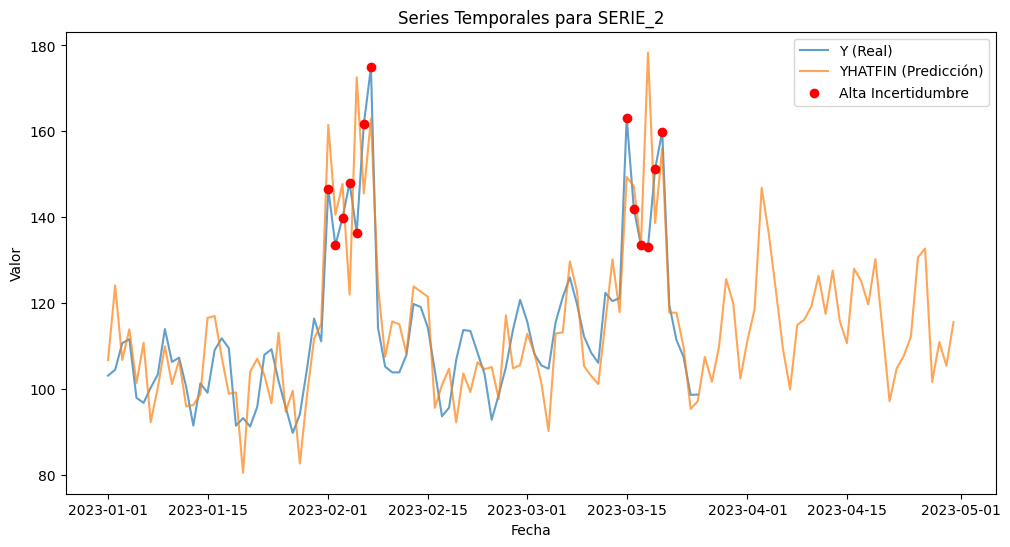

In [16]:
import matplotlib.pyplot as plt

# Filtrar una serie específica
serie = "SERIE_2"
df_serie = df[df["KEY"] == serie]

# Crear un gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_serie["FECHA"], df_serie["Y"], label="Y (Real)", alpha=0.7)
plt.plot(df_serie["FECHA"], df_serie["YHATFIN"], label="YHATFIN (Predicción)", alpha=0.7)

# Resaltar períodos de alta incertidumbre
promo_dates = df_serie[df_serie["X"] == 1]["FECHA"]
plt.scatter(promo_dates, df_serie[df_serie["X"] == 1]["Y"], color="red", label="Alta Incertidumbre", zorder=5)

plt.title(f"Series Temporales para {serie}")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()


In [17]:
# df = generar_datos(n_series=n_series, n_points=n_points, seed=123, start_date="2023-01-01",noise_std=noise_std, fore_std=fore_std)
df = assign_data_sets(df, date_col="FECHA", future_col="FUTURE", calib_ratio=0.4)


In [62]:
def extended_theta_forecaster(scores, time_index, seasonal_period, ahead, exogenous_vars=None):
    """
    Extiende el modelo Theta para incluir variables exógenas.

    Parámetros:
    - scores (np.ndarray): Serie temporal de valores.
    - time_index (pd.DatetimeIndex): Índice temporal correspondiente.
    - seasonal_period (int): Período estacional.
    - ahead (int): Horizonte de predicción.
    - exogenous_vars (pd.DataFrame): Variables exógenas (opcional).

    Retorna:
    - forecast (float): Predicción ajustada para el horizonte `ahead`.
    """
    # Entrenar modelo Theta
    score_series = pd.Series(scores, index=time_index)
    theta_model = ThetaModel(score_series, period=seasonal_period)
    theta_fit = theta_model.fit()
    theta_forecast = theta_fit.forecast(ahead)

    # Si no hay variables exógenas, retorna el pronóstico Theta puro
    if exogenous_vars is None:
        return theta_forecast.iloc[-1]

    # Calcular valores ajustados usando forecast_components
    components = theta_fit.forecast_components(steps=len(scores))
    fitted_values = components.sum(axis=1)  # Suma de los componentes
    residuals = scores - fitted_values.values  # Calcular residuales

    # Asegurar que X_train y residuals tienen la misma longitud
    min_len = min(len(residuals), len(exogenous_vars.iloc[:-ahead]))
    X_train = exogenous_vars.iloc[:min_len].values.reshape(-1, 1)
    residuals_aligned = residuals[:min_len]

    # Dividir datos en entrenamiento y prueba
    X_test = exogenous_vars.iloc[-ahead:].values.reshape(-1, 1)
    y_train = residuals_aligned

    # Ajustar modelo Ridge con variables exógenas
    ridge_model = Ridge()
    ridge_model.fit(X_train, y_train)

    # Predecir residual ajustado
    exog_forecast = ridge_model.predict(X_test)

    # Combinar pronósticos: Theta base + ajuste con variables exógenas
    adjusted_forecast = theta_forecast.iloc[-1] + exog_forecast[-1]
    return adjusted_forecast


In [63]:
def quantile_integrator_log_scorecaster_with_diagnostics(
    scores, 
    alpha, 
    lr, 
    T_burnin, 
    Csat, 
    KI, 
    ahead, 
    seasonal_period, 
    time_index, 
    lr_option,
    integrate,  
    scorecast, 
    model_type,
    X=None
):
    """

    Calcula intervalos dinámicos de predicción con diagnóstico detallado.

    Retorna:
    - qs (np.ndarray): Intervalos ajustados dinámicamente.
    - logs (dict): Logs detallados de cada componente.
    """
    T_test = scores.shape[0]
    qs = np.zeros((T_test,))
    qts = np.zeros((T_test,))
    integrators = np.zeros((T_test,))
    scorecasts = np.zeros((T_test,))
    covereds = np.zeros((T_test,))

    # Logs para análisis posterior
    logs = {"proportional": [], "integral": [], "derivative": [], "coverage": []}


    for t in tqdm(range(T_test)):
        t_pred = t - ahead + 1
        if t_pred < 0:
            continue

        # ================================
        # Tasa de aprendizaje dinámica (P)  
        # ================================
        t_lr_min = max(t - T_burnin, 0)
        lr_t = calculate_dynamic_learning_rate(
            scores=scores,
            t_lr_min=t_lr_min,
            t=t,
            lr=lr,
            alpha=alpha,
            covereds=covereds,
            option=lr_option
        )


        # ======================================
        # Componente Proporcional y Gradiente (P)
        # ======================================
        covereds[t] = qs[t] >= scores[t]  # Determinar si el cuantil cubre el error
        grad = alpha if covereds[t_pred] else -(1 - alpha)
        proportional_update = -lr_t * grad
        logs["proportional"].append(proportional_update)

        # ============================
        # Componente Integral (I)
        # ============================
        integrator_arg = (1 - covereds)[:t_pred].sum() - (t_pred) * alpha
        # integrator = (np.tan(integrator_arg * np.log(t_pred + 1) / (Csat * (t_pred + 1))) if integrate else 0 )
        integrator = saturation_fn_log(integrator_arg, t_pred, Csat, KI) if integrate else 0
        integrators[t] = integrator
        logs["integral"].append(integrator)

        # ================================
        # Componente Derivativo (D)
        # ================================

        if scorecast and t_pred > T_burnin and t + ahead < T_test:
            exogenous_vars = X.iloc[:t_pred] if X is not None else None
            scorecasts[t + ahead] = extended_theta_forecaster(
                scores=scores[:t_pred],
                time_index=pd.date_range(start=time_index.iloc[0], periods=len(scores[:t_pred]), freq='D'),
                seasonal_period=seasonal_period,
                ahead=ahead,
                exogenous_vars=exogenous_vars
            )


        logs["derivative"].append(scorecasts[t])

        # Registrar cobertura
        logs["coverage"].append(covereds[t])

        # Alertar si la cobertura es baja
        # if covereds[t] < coverage_threshold:
        #     print(f"⚠️ Cobertura baja en el paso {t}: {covereds[t]}")

        # ================================
        # Actualización del Cuantil
        # ================================
        if t < T_test - 1:
            qts[t + 1] = qts[t] + proportional_update
            
            integrators[t + 1] = integrator if integrate else 0
            qs[t + 1] = qts[t + 1] + integrators[t + 1]
            if scorecast:
                qs[t + 1] += scorecasts[t + 1]
    
    return qs, logs


In [73]:
def apply_pdi_with_calibration_with_diagnostics(
    df, 
    key_col, 
    date_col, 
    value_col, 
    pred_col, 
    lower_col, 
    upper_col, 
    alpha, 
    lr, 
    T_burnin, 
    Csat, 
    KI, 
    ahead, 
    seasonal_period, 
    set_col,
    X_col=None,  # Nombre de la columna con variables exógenas
    lr_option='proportional_range',
    integrate=True,  
    scorecast=True, 
    model_type='theta',
    smooth_method='volatil_weighted'
):
    """
    Ahora incluye el manejo de variables exógenas (X_col).
    """
    results = []
    all_logs = {}

    for key, group in df.groupby(key_col):
        group = group.sort_values(by=date_col)

        # Dividir los datos en conjuntos de entrenamiento, calibración y prueba
        train, calib, test = split_data_by_set(group, set_col=set_col)

        y_train = train[value_col].dropna().values
        y_pred_train = train[pred_col].dropna().values
        scores_train = np.abs(y_train - y_pred_train)
        time_index_train = pd.to_datetime(train[date_col])

        # Extraer variables exógenas
        X_train = train[X_col] if X_col else None

        qs_calib, logs = quantile_integrator_log_scorecaster_with_diagnostics(
            scores=scores_train,
            alpha=alpha,
            lr=lr,
            T_burnin=T_burnin,
            Csat=Csat,
            KI=KI,
            ahead=ahead,
            seasonal_period=seasonal_period,
            time_index=time_index_train,
            lr_option=lr_option,
            integrate=integrate,
            scorecast=scorecast,
            model_type=model_type,
            X=X_train
        )

        all_logs[key] = logs

        # Aplicar los intervalos a las particiones
        # Hacer copias explícitas de los subconjuntos
        train = train.copy()
        calib = calib.copy()
        test = test.copy()

        # Modificar las columnas usando `.loc`
        train.loc[:, lower_col] = train[pred_col] - qs_calib
        train.loc[:, upper_col] = train[pred_col] + qs_calib
        calib.loc[:, lower_col] = calib[pred_col] - qs_calib[-1]
        calib.loc[:, upper_col] = calib[pred_col] + qs_calib[-1]
        test.loc[:, lower_col] = test[pred_col] - qs_calib[-1]
        test.loc[:, upper_col] = test[pred_col] + qs_calib[-1]


        results.append(pd.concat([train, calib, test]))

    return pd.concat(results), all_logs


In [90]:
# Parámetros de la función
alpha = 0.1  # Nivel de significancia (90% cobertura)
lr = 0.01  # Tasa de aprendizaje
T_burnin = 10  # Periodo de calentamiento para el componente integral y derivativo
Csat = 2.5  # Constante de saturación para el componente integral
KI = 1.0  # Escala del componente integral
ahead = 1  # Horizonte de predicción (1 día adelante)
seasonal_period = 7  # Período estacional (semanal en este caso)
smooth_method = "volatil_weighted"  # Método para suavizar el cuantil final

# Aplicar la función
df_pdi, logs = apply_pdi_with_calibration_with_diagnostics(
    df=df,
    key_col="KEY",
    date_col="FECHA",
    value_col="Y",
    pred_col="YHATFIN",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha,
    lr=lr,
    T_burnin=T_burnin,
    Csat=Csat,
    KI=KI,
    ahead=ahead,
    seasonal_period=seasonal_period,
    set_col="SET",
    X_col="X",  # Variables exógenas
    lr_option="proportional_range",
    integrate=True,
    scorecast=True,
    model_type="theta",
    smooth_method=smooth_method
)


100%|██████████| 50/50 [00:00<00:00, 205.14it/s]


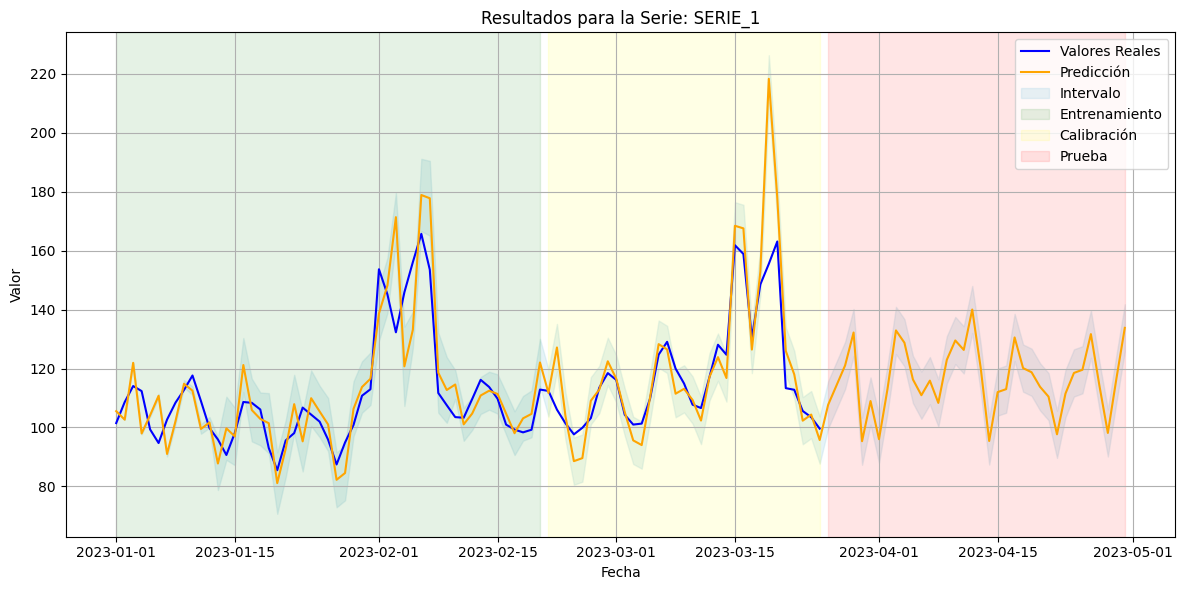

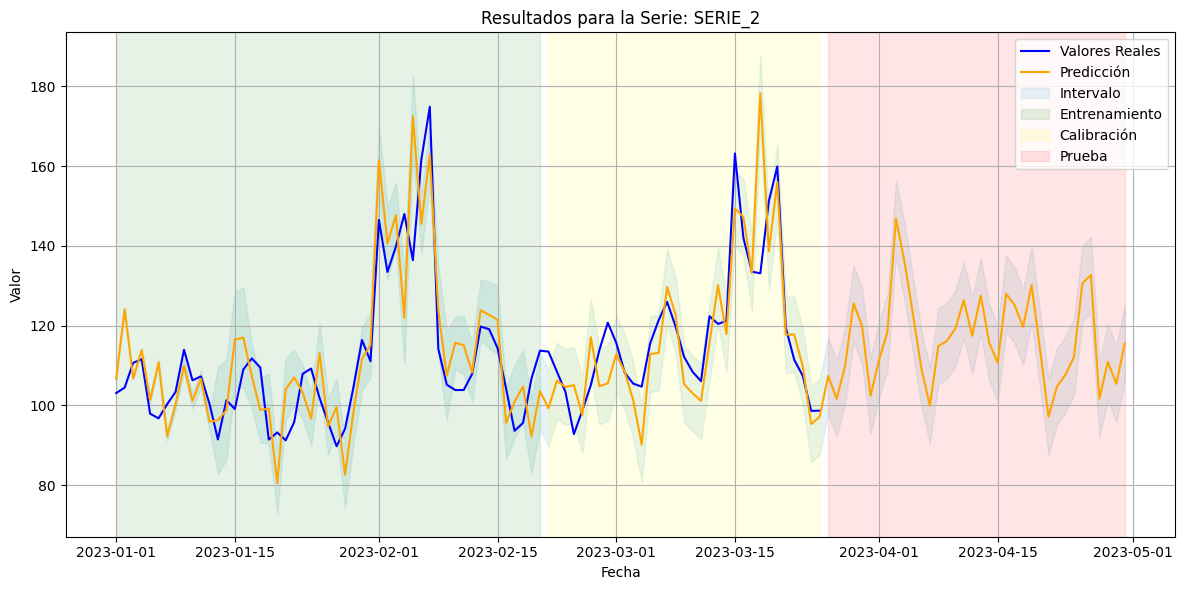

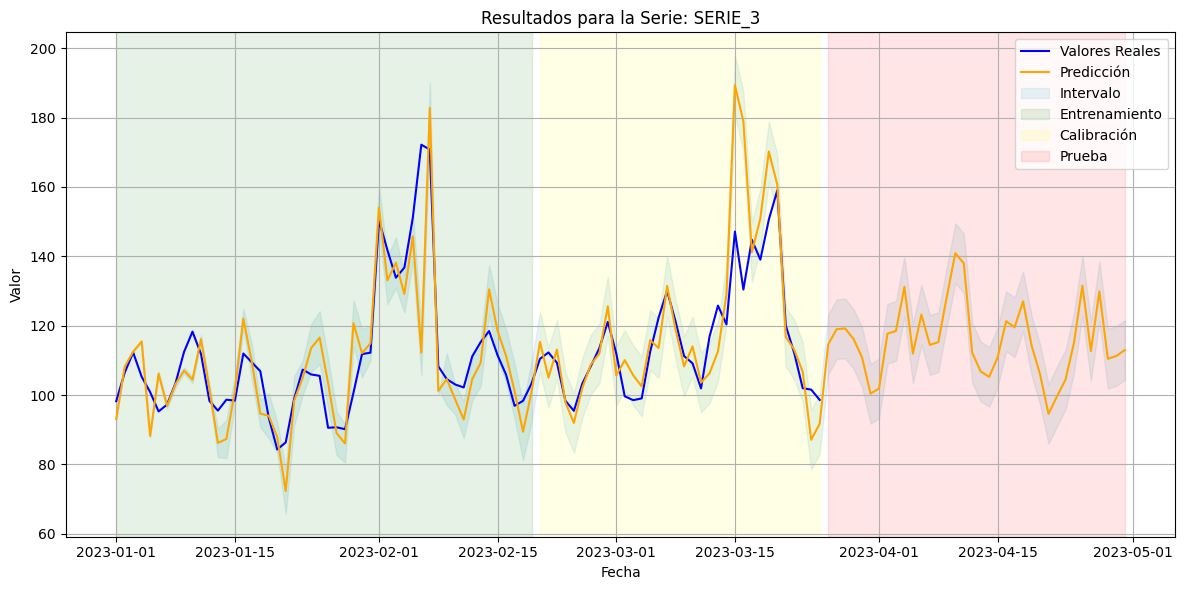

In [91]:
unique_keys = df_pdi['KEY'].unique()

for key in unique_keys:
    plot_series_results_with_sets(df_pdi, key=key)

In [77]:
# plot_logs(logs)

In [93]:
# Dividir el DataFrame en TRAIN, CALIBRATION y TEST
train_df = df_pdi[df_pdi["SET"] == "TRAIN"]
calib_df = df_pdi[df_pdi["SET"] == "CALIBRATION"]
test_df = df_pdi[df_pdi["SET"] == "TEST"]

# Calcular métricas por serie (KEY) para el conjunto de calibración
calib_metrics_by_key = calculate_metrics(
    calib_df,
    value_col="Y",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha,
    condition_col="KEY"
)

# Mostrar resultados
print("Métricas por KEY (Calibración):")
print(calib_metrics_by_key)


Métricas por KEY (Calibración):
     Group  Marginal Coverage  Coverage Deviation  Average Region Size  \
0  SERIE_1           0.757576           -0.142424            16.003977   
1  SERIE_2           0.727273           -0.172727            19.031070   
2  SERIE_3           0.705882           -0.194118            17.186856   

   Winkler Score  
0      66.791808  
1      57.741042  
2      77.430117  


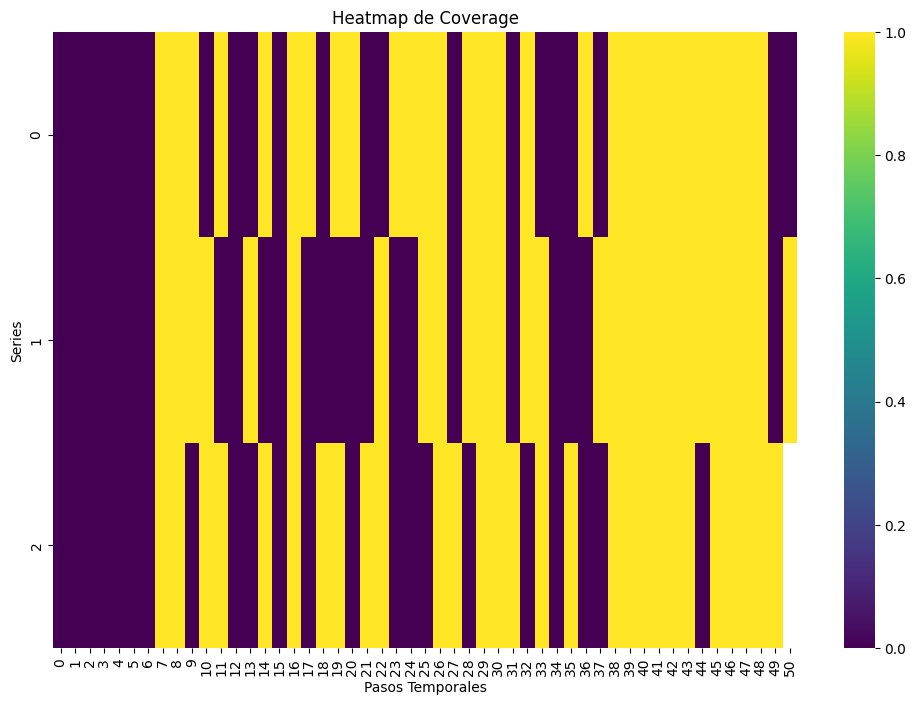

In [79]:
plot_heatmap(logs, component="coverage")

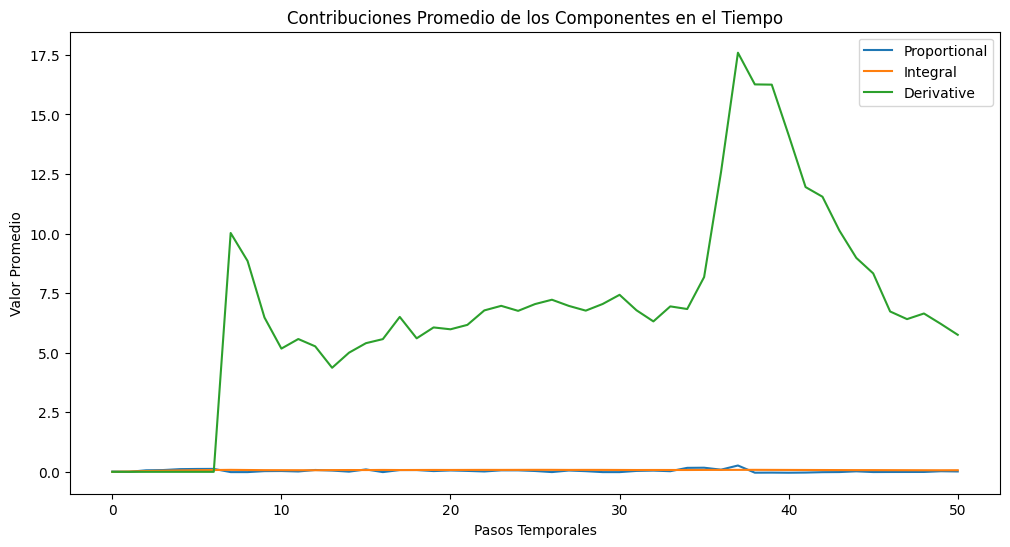

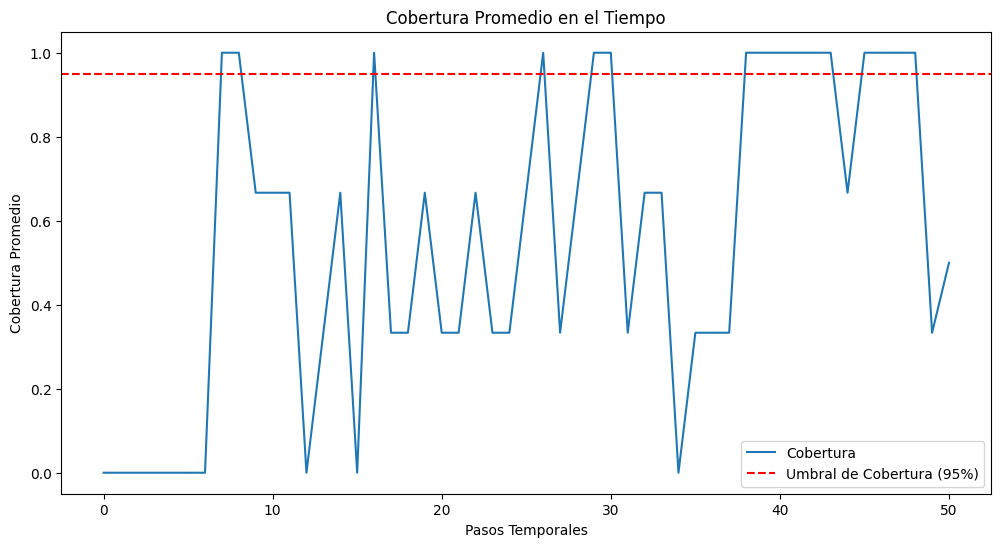

In [80]:
plot_logs_agg(aggregate_logs_average(logs))

In [81]:
calib_metrics = calculate_metrics(
    calib_df,
    value_col="Y",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha
)
calib_metrics

,Group,Marginal Coverage,Coverage Deviation,Average Region Size,Winkler Score
0,Global,0.71,-0.19,17.381027,68.739796
